<a href="https://colab.research.google.com/github/calistasalscpw/Selena-Finance-Tracker/blob/main/Selena_Shopee_rev_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone Project - Selena (Shopee)

**Proses Analisis oleh Model ML (Menggunakan File .pkl)**

- **Backend kemudian memuat model ML yang sudah dilatih (disimpan dalam format .pkl) menggunakan library Pickle di Python.**
- Model ML ini memproses data transaksi pengguna yang sudah diambil dari database untuk melakukan beberapa tugas analisis:
    - Arus Kas: Mengidentifikasi pola pemasukan dan pengeluaran.
    - Saran Keuangan: Berdasarkan analisis tren keuangan pengguna, model bisa memberikan saran, misalnya mengurangi pengeluaran di kategori tertentu.
    - Deteksi Anomali Pengeluaran: Model ML mendeteksi adanya transaksi atau pengeluaran yang tidak biasa atau mencurigakan.

Pengembalian Hasil Analisis ke Backend (ML ke CC)

- Model ML menghasilkan output analisis, seperti rekomendasi keuangan atau deteksi anomali, yang dikonversi ke **format JSON**.
- Backend menerima hasil ini dan menggabungkannya menjadi satu respons JSON yang siap dikirim ke aplikasi mobile.

## Import Libraries

In [288]:
import csv
import json
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

## Preprocessing Data

In [289]:
#Min-Max Scaler Initialization
scaler = MinMaxScaler(feature_range=(0, 1))

In [290]:
#FUNGSI UNTUK PREPROCESSING DATA

def preprocess_data(data_path):
  # Membaca file dataset
  df = pd.DataFrame(pd.read_csv(data_path))

  # Mengambil kolom yang dibutuhkan
  data_filtered = df[['TGL_TRAN', 'MUTASI_DEBET', 'MUTASI_KREDIT']].copy()

  # Menghapus titik dari kolom 'MUTASI_DEBET'
  #data_filtered['Total Pembayaran'] = data_filtered['Total Pembayaran'].astype(str).str.replace('.', '', regex=False)

  # Mengkonversi tipe data
  data_filtered['MUTASI_DEBET'] = pd.to_numeric(data_filtered['MUTASI_DEBET'])
  data_filtered['MUTASI_KREDIT'] = pd.to_numeric(data_filtered['MUTASI_KREDIT'])
  data_filtered['TGL_TRAN'] = pd.to_datetime(data_filtered['TGL_TRAN']).dt.date

  #Mengubah Nilai dalam ribuan
  data_filtered['MUTASI_DEBET'] = data_filtered['MUTASI_DEBET'] / 1000
  data_filtered['MUTASI_KREDIT'] = data_filtered['MUTASI_KREDIT'] / 1000

  #Rescaling dengan MinMaxScaler
  data_filtered[['MUTASI_DEBET']] = scaler.fit_transform(data_filtered[['MUTASI_DEBET']])
  data_filtered[['MUTASI_KREDIT']] = scaler.fit_transform(data_filtered[['MUTASI_KREDIT']])

  # Assign value variabel time dan series
  time = data_filtered['TGL_TRAN'].tolist()
  expense = data_filtered['MUTASI_DEBET'].tolist()
  income = data_filtered['MUTASI_KREDIT'].tolist()

  return time, expense, income

## Preprocessing Data and Global Variables

Fungsi `preprocess_data` sudah melakukan preprocessing dari membaca dataset, memilih kolom yang dibutuhkan, serta parsing data.

In [291]:
### Inisiasi variabel global ###

DATA_PATH = './data/Dataset_BRI.csv'
TIME, SERIES, INCOME = preprocess_data(DATA_PATH)

EXPENSE_SCALED = scaler.inverse_transform(np.array(SERIES).reshape(-1,1)).flatten()
INCOME_SCALED = scaler.inverse_transform(np.array(INCOME).reshape(-1,1)).flatten()

# Model
split_ratio = 0.8
SPLIT_TIME = int(len(SERIES) * split_ratio)
WINDOW_SIZE = 32
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100

## Defining Functions
---



Terdiri atas beberapa fungsi:
- Fungsi `plot_series`: Berisi matplotlib untuk visualisasi data berupa time series
- Fungsi `train_val_split`: Digunakan untuk membagi time series menjadi data latih dan data validasi
- Fungsi `create_windowed_dataset`: Digunakan untuk membuat dataset berbentuk windowed

In [292]:
def plot_series(time, series, format="-", start=0, end=None):
    EXPENSE_SCALED = scaler.inverse_transform(np.array(series).reshape(-1,1)).flatten()
    plt.figure(figsize=(16, 8))
    plt.plot(time[start:end], EXPENSE_SCALED[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Jumlah uang (dalam ribuan Rupiah)")
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))  # Menyesuaikan format tanggal
    plt.gcf().autofmt_xdate()  # Memutar tanggal agar tidak bertabrakan
    plt.show()

In [293]:
def train_val_split(time, series):
    """Split time series into train and validation sets"""
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [294]:
def create_windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    """
    Membuat dataset dalam bentuk windowed untuk time series.

    Parameters:
    - series: Data time series dalam bentuk array atau list.
    - window_size: Jumlah langkah dalam satu jendela input.
    - batch_size: Jumlah data yang diproses dalam satu batch.
    - shuffle_buffer: Ukuran buffer untuk pengacakan data.

    Returns:
    - dataset: Dataset dengan pasangan input-output berdasarkan window size.
    """

    # Konversi data series ke dalam dataset tensorflow
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Membuat window untuk setiap sample
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Konversi setiap window ke dalam bentuk batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Memisahkan window menjadi input (features) dan output (label)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Mengacak data menggunakan shuffle buffer
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Membuat batch data
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [295]:
def create_uncompiled_model():
    """Define uncompiled model

    Returns:
        tf.keras.Model: uncompiled model
    """

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2),
        tf.keras.layers.LSTM(16, dropout=0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [296]:
def create_model():
    """Creates and compiles the model

    Returns:
        tf.keras.Model: compiled model
    """

    model = create_uncompiled_model()

    model.compile(loss = tf.keras.losses.Huber(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["mae"])

    return model

## Plot Series

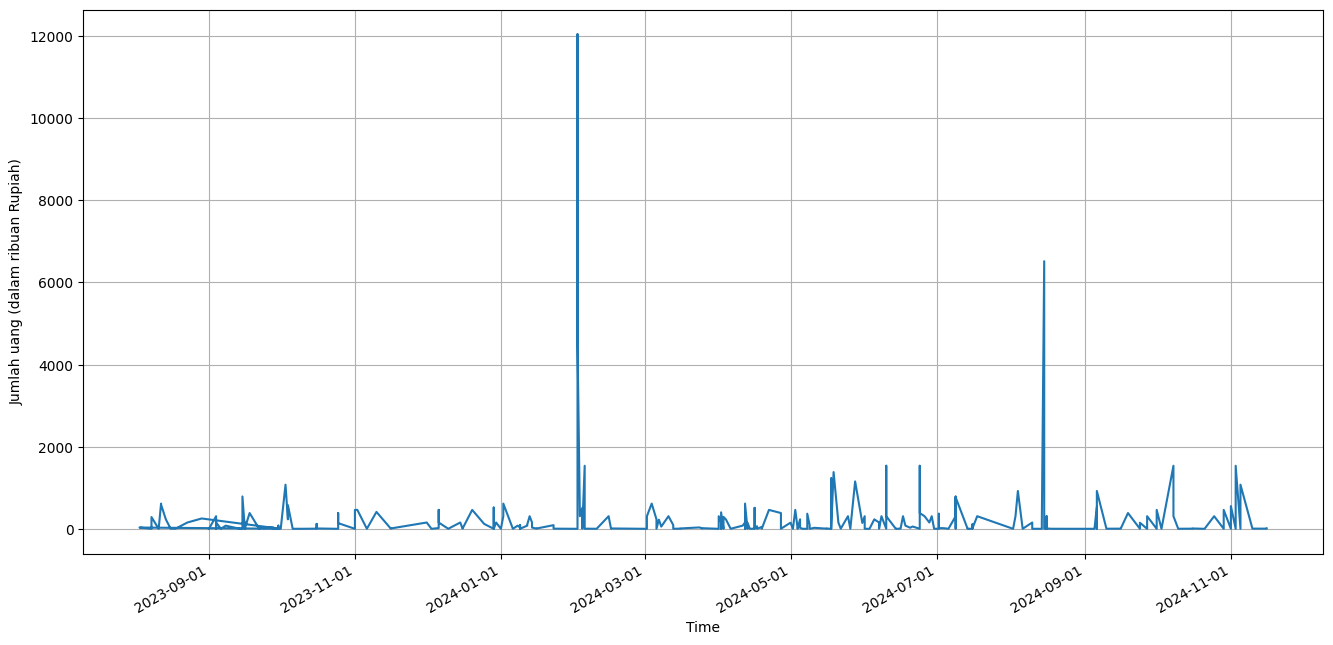

In [297]:
plot_series(TIME, SERIES)

In [298]:
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)
series_train_windowed = create_windowed_dataset(series_train)
series_valid_windowed = create_windowed_dataset(series_valid)

# model
uncompiled_model = create_uncompiled_model()

In [299]:
example_batch = series_train_windowed.take(1)

try:
	predictions = uncompiled_model.predict(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	print("Your current architecture is compatible with the windowed dataset! :)")
	print(f"predictions have shape: {predictions.shape}")

Your current architecture is compatible with the windowed dataset! :)
predictions have shape: (16, 1)


c:\Program Files\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [300]:
model = create_model()

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 50) if epoch < 10 else 1e-3)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(series_train_windowed, validation_data=series_valid_windowed, epochs=100, callbacks=[lr_schedule, early_stopping])

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.5193e-04 - mae: 0.0208 - val_loss: 7.1363e-04 - val_mae: 0.0273 - learning_rate: 1.0000e-04
Epoch 2/100


c:\Program Files\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0080 - mae: 0.0356 - val_loss: 7.1186e-04 - val_mae: 0.0279 - learning_rate: 1.0312e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0082 - mae: 0.0372 - val_loss: 7.1052e-04 - val_mae: 0.0277 - learning_rate: 1.0633e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0030 - mae: 0.0258 - val_loss: 7.1132e-04 - val_mae: 0.0275 - learning_rate: 1.0965e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0019 - mae: 0.0235 - val_loss: 7.1210e-04 - val_mae: 0.0274 - learning_rate: 1.1307e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0040 - mae: 0.0279 - val_loss: 7.1300e-04 - val_mae: 0.0280 - learning_rate: 1.1659e-04
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0027 - mae: 0.0272 - val_loss: 7.1447e-04 - val_mae: 0.0274 - learning_rate: 1.2023e-04
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0022 - mae: 0.0229 - val_loss: 7.1457e-04 - val_ma

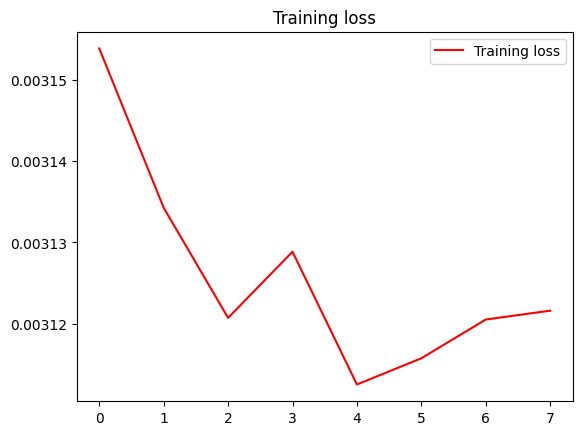

In [312]:
# Plot the training loss for each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

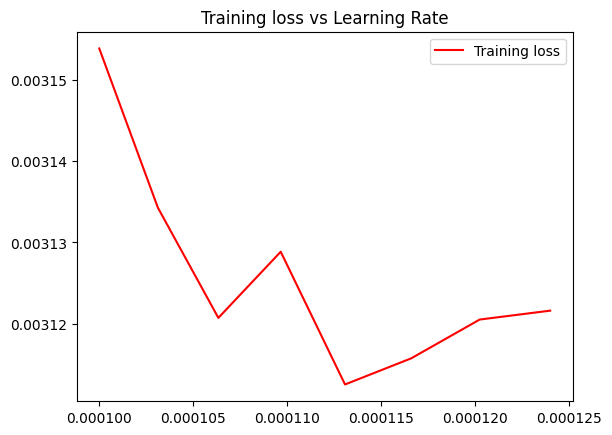

In [313]:
# Plot the training loss for each learning rate

lr = history.history['learning_rate']

plt.plot(lr, loss, 'r', label='Training loss')
plt.title('Training loss vs Learning Rate')
plt.legend(loc=0)
plt.show()

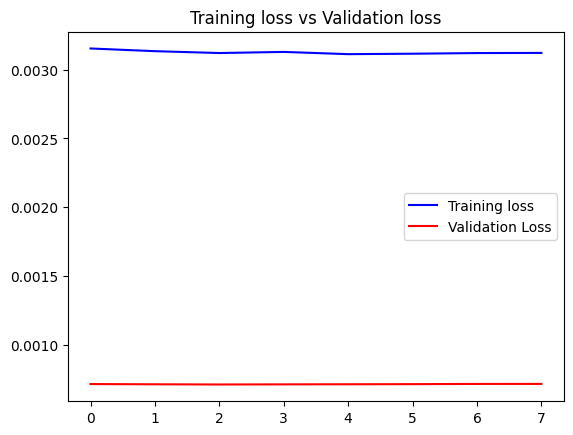

In [314]:
# Plot the training loss for each learning rate

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training loss vs Validation loss')
plt.legend()
plt.show()

## Evaluate Forecast

Using MAE and MSE as metrics to evaluate forecast (prediction)

In [305]:
def compute_metrics(true_series, forecast):
    """Computes MSE and MAE metrics for the forecast"""
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

More efficient way to forecast

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [306]:
def model_forecast(model, series, window_size):
    """Generates a forecast using your trained model"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [307]:
# Compute the forecast for the validation dataset. Remember you need the last WINDOW SIZE values to make the first prediction
rnn_forecast = model_forecast(model, SERIES[SPLIT_TIME-WINDOW_SIZE:-1], WINDOW_SIZE).squeeze()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step


<Figure size 1000x600 with 0 Axes>

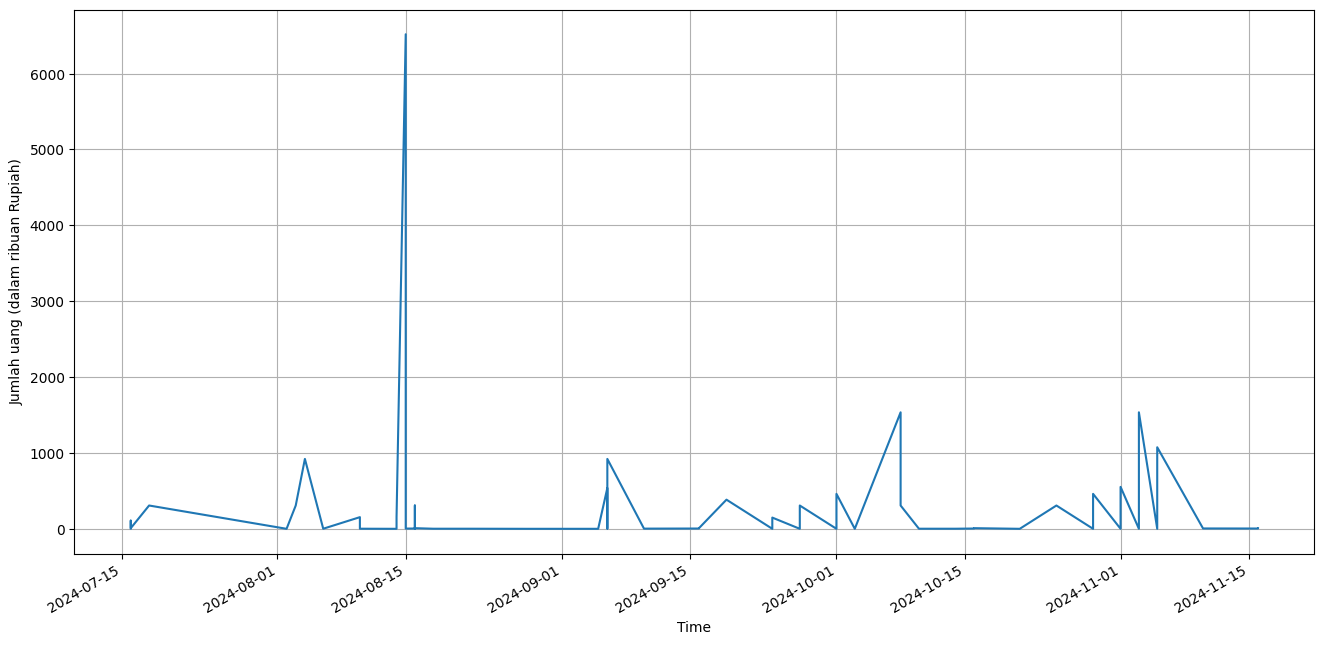

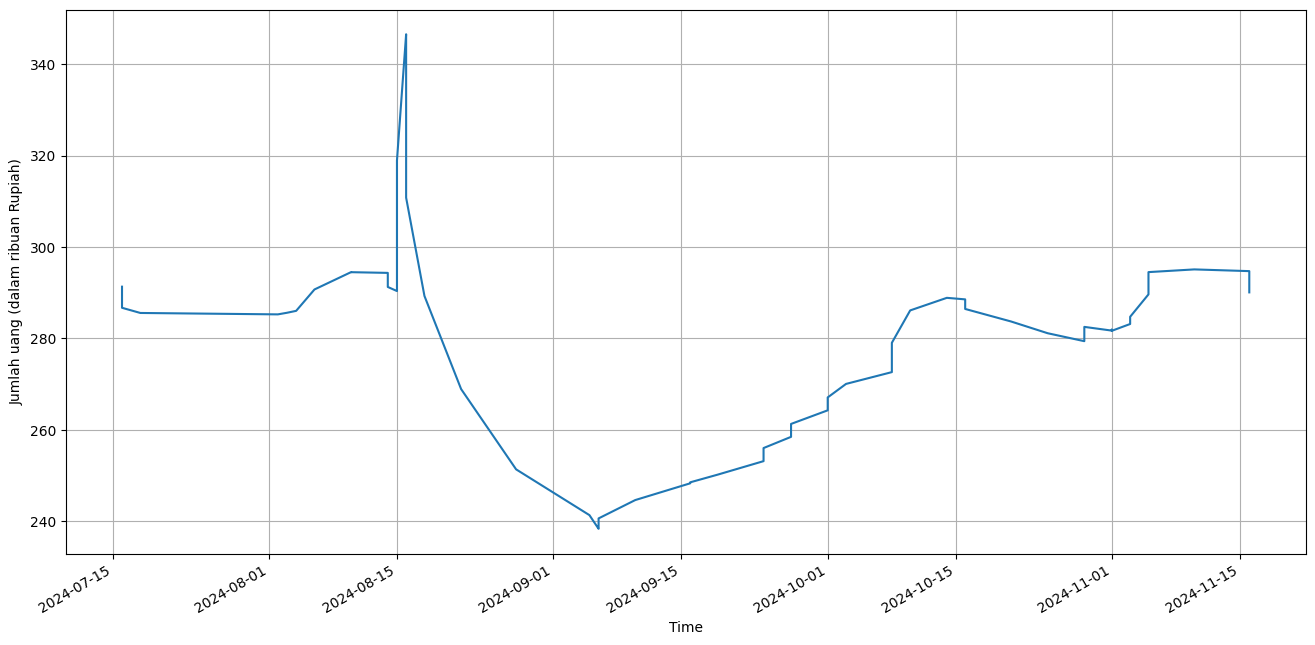

In [308]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [309]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.01, mae: 0.03 for forecast


Saving metrics

In [310]:
# Save metrics into a dictionary
metrics_dict = {
    "mse": float(mse),
    "mae": float(mae)
}

# Save your metrics in a binary file 
with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)